# Chapter 12: Predicting Oil Reservoir Performance (The Tarner Method)
**Author:** Ade Anggi Naluriawan Santoso

**Objective:**
In this notebook, we will predict the future production profile ($N_p$, $G_p$, Reservoir Pressure, and GOR) for a volumetric solution-gas drive reservoir.

**The Challenge:**
As pressure drops below the Bubble Point:
1.  Gas evolves from the oil ($R_s$ decreases).
2.  Free gas saturation increases ($S_g$ increases).
3.  Relative permeability ratio ($k_{rg}/k_{ro}$) increases drastically.
4.  **Result:** The Producing GOR shoots up, and oil production efficiency drops.

**The Solution (Tarner Method):**
The Tarner method (1944) combines two physical laws to solve for future production steps:
1.  **Material Balance Equation (MBE):** Conservation of mass.
2.  **Instantaneous GOR Equation:** Governed by Darcy's Law and Relative Permeability.

Since both equations depend on each other (you need Saturation to get GOR, but you need Production to get Saturation), we must solve them **iteratively** for each pressure step.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Plotting Style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

## 1. Input Data Setup

To perform the Tarner Method, we need detailed PVT data and Relative Permeability data.

**Reservoir Parameters:**
* Initial Oil In Place ($N$): 10 MMSTB
* Initial Pressure ($P_i$): 4000 psi (Bubble Point)
* Connate Water ($S_{wc}$): 0.20
* Critical Gas Saturation ($S_{gc}$): 0.05

In [2]:
# --- RESERVOIR CONSTANTS ---
N = 10e6        # STB
Swc = 0.20      # Connate Water
Pi = 4000       # Initial Pressure (psi)
Pb = 4000       # Bubble Point (psi)

# --- 1. PVT DATA (Black Oil Properties) ---
# Usually these come from a lab report. We define them as arrays here.
# Columns: Pressure, Bo, Rs, Bg, viso, visg
pvt_data = {
    'Pressure': [4000, 3500, 3000, 2500, 2000, 1500, 1000],
    'Bo':       [1.32, 1.31, 1.29, 1.27, 1.25, 1.23, 1.21],   # rb/stb
    'Rs':       [700,  640,  570,  500,  420,  330,  240],    # scf/stb
    'Bg':       [0.00080, 0.00092, 0.00110, 0.00135, 0.00175, 0.00240, 0.00360], # rb/scf
    'mu_o':     [0.40, 0.42, 0.45, 0.50, 0.58, 0.70, 0.90],   # cp
    'mu_g':     [0.022, 0.021, 0.020, 0.019, 0.018, 0.017, 0.016] # cp
}
df_pvt = pd.DataFrame(pvt_data)

# Calculate Two-Phase FVF (Bt) = Bo + (Rsi - Rs)*Bg
# We need Rsi (Rs at Bubble Point)
Rsi = df_pvt.loc[0, 'Rs']
df_pvt['Bt'] = df_pvt['Bo'] + (Rsi - df_pvt['Rs']) * df_pvt['Bg']

# Create Interpolators for PVT (to fetch values at any pressure)
f_Bo = interp1d(df_pvt['Pressure'], df_pvt['Bo'], kind='cubic')
f_Rs = interp1d(df_pvt['Pressure'], df_pvt['Rs'], kind='cubic')
f_Bg = interp1d(df_pvt['Pressure'], df_pvt['Bg'], kind='cubic')
f_Bt = interp1d(df_pvt['Pressure'], df_pvt['Bt'], kind='cubic')
f_muo = interp1d(df_pvt['Pressure'], df_pvt['mu_o'], kind='cubic')
f_mug = interp1d(df_pvt['Pressure'], df_pvt['mu_g'], kind='cubic')

# --- 2. RELATIVE PERMEABILITY DATA (Kg/Ko) ---
# Ratio of gas perm to oil perm vs Liquid Saturation (SL = So + Swc)
# As liquid saturation drops (more gas), kg/ko skyrockets.
rel_perm_data = {
    'SL':     [1.0, 0.98, 0.95, 0.90, 0.85, 0.80, 0.70, 0.60, 0.50],
    'kg_ko':  [0.0, 0.0,  0.01, 0.08, 0.20, 0.45, 1.50, 4.50, 15.0]
}
df_rel = pd.DataFrame(rel_perm_data)

# Interpolator for RelPerm
# Note: x-axis is SL (Total Liquid Saturation)
f_kgko = interp1d(df_rel['SL'], df_rel['kg_ko'], kind='linear', fill_value="extrapolate")

print("--- PVT Data Sample ---")
print(df_pvt[['Pressure', 'Bo', 'Rs', 'Bg']].head())

--- PVT Data Sample ---
   Pressure    Bo   Rs       Bg
0      4000  1.32  700  0.00080
1      3500  1.31  640  0.00092
2      3000  1.29  570  0.00110
3      2500  1.27  500  0.00135
4      2000  1.25  420  0.00175


## 2. The Tarner Algorithm

We calculate performance in pressure steps (e.g., 4000 -> 3800 psi). For each step:

1.  **Assume** a cumulative oil production at the end of the step ($N_{p2}$).
2.  **Calculate Oil Saturation ($S_o$):**
    $$S_o = (1 - S_{wc}) \left( \frac{(N - N_{p2}) B_{o2}}{N B_{oi}} \right)$$
    *This tells us how much space the remaining oil occupies.*
3.  **Get $k_{rg}/k_{ro}$** based on total liquid saturation ($S_L = S_o + S_{wc}$).
4.  **Calculate Instantaneous GOR ($R_{gor}$):**
    $$R = R_s + \left( \frac{k_{rg}}{k_{ro}} \right) \left( \frac{\mu_o B_o}{\mu_g B_g} \right)$$
5.  **Calculate Average GOR ($R_{avg}$)** for the interval.
6.  **Calculate Gas Production ($G_p$):**
    $$G_{p2} = G_{p1} + (N_{p2} - N_{p1}) \cdot R_{avg}$$
7.  **Verify with Material Balance Equation (MBE):**
    The MBE allows us to solve for $N_{p2}$ independently:
    $$N_{p2} = \frac{N (B_{t2} - B_{ti})}{B_{t2} + (R_{p2} - R_{si}) B_{g2}}$$
    *(Wait, the Tarner method typically rearranges this. A simpler check is: Does the assumed $N_p$ satisfy the MBE balance?)*
    
    A robust way is to solve:
    $$Error = N_{p,assumed} - N_{p,calculated}$$
    
    Where $N_{p,calc}$ uses the gas produced ($G_p$) to back-calculate oil:
    $$N_{p,calc} = \frac{N(B_t - B_{ti}) - G_{p2}B_g}{B_o - R_s B_g}$$
    
8.  **Iterate** until Error is close to zero.

In [3]:
def solve_tarner_step(P_old, P_new, Np_old, Gp_old, N, Swc, Bti):
    """
    Solves one pressure decrement step using Tarner's iterative method.
    """
    # 1. Get PVT properties at P_new
    Bo = f_Bo(P_new)
    Bg = f_Bg(P_new)
    Rs = f_Rs(P_new)
    Bt = f_Bt(P_new)
    mu_o = f_muo(P_new)
    mu_g = f_mug(P_new)
    Boi = f_Bo(4000) # Constant
    
    # 2. Get PVT properties at P_old (for averaging GOR)
    Bo_old = f_Bo(P_old)
    Bg_old = f_Bg(P_old)
    Rs_old = f_Rs(P_old)
    mu_o_old = f_muo(P_old)
    mu_g_old = f_mug(P_old)
    
    # Calculate previous kg/ko for averaging
    # Determine So_old
    So_old = (1 - Swc) * ((N - Np_old) * Bo_old) / (N * Boi)
    SL_old = So_old + Swc
    kgko_old = f_kgko(SL_old)
    
    GOR_old = Rs_old + kgko_old * (mu_o_old * Bo_old) / (mu_g_old * Bg_old)
    
    # 3. Iteration Loop
    # Initial Guess for Delta Np (Production during this step)
    # A simplified guess: 1% of N
    dNp_guess = 0.01 * N 
    
    tolerance = 1000 # STB
    
    for i in range(20): # Max 20 iterations
        Np_guess = Np_old + dNp_guess
        
        # A. Material Balance Check
        # Calculate Oil Saturation at assumed Np
        So = (1 - Swc) * ((N - Np_guess) * Bo) / (N * Boi)
        SL = So + Swc
        
        # Look up kg/ko
        kgko = f_kgko(SL)
        
        # Calculate Instantaneous GOR at P_new
        GOR_new = Rs + kgko * (mu_o * Bo) / (mu_g * Bg)
        
        # Calculate Average GOR for the interval
        R_avg = (GOR_old + GOR_new) / 2
        
        # Calculate Cumulative Gas Produced (Gp)
        dGp = dNp_guess * R_avg
        Gp_guess = Gp_old + dGp
        
        # B. Back-Calculate Np using the General MBE
        # Np = [ N(Bt - Bti) - Gp * Bg ] / (Bo - Rs * Bg) ? 
        # Let's derive simpler form for Solution Gas Drive (No water influx, no gas cap):
        # F = N * Eo  =>  Np(Bt + (Rp-Rsi)Bg) = N(Bt - Bti)
        # We know Gp = Np * Rp. So Np*Rp = Gp.
        # Np*Bt + (Gp - Np*Rsi)*Bg = N(Bt - Bti)
        # Np(Bt - Rsi*Bg) + Gp*Bg = N(Bt - Bti)
        # Np = [ N(Bt - Bti) - Gp*Bg ] / (Bt - Rsi*Bg)
        # Note: (Bt - Rsi*Bg) simplifies to Bo - Rs*Bg + Rsi*Bg - Rsi*Bg = Bo - Rs*Bg ??
        # Let's check def: Bt = Bo + (Rsi - Rs)Bg. 
        # Denominator: Bo + (Rsi - Rs)Bg - Rsi*Bg = Bo - Rs*Bg. Correct.
        
        numerator = N * (Bt - Bti) - (Gp_guess * Bg)
        denominator = Bo - (Rs * Bg)
        
        Np_calc = numerator / denominator
        
        # C. Check Error
        error = Np_calc - Np_guess
        
        if abs(error) < tolerance:
            # Converged
            return Np_calc, Gp_guess, GOR_new
        else:
            # Update guess (Relaxation)
            dNp_guess = dNp_guess + 0.5 * error
            
    return Np_guess, Gp_guess, GOR_new # Return best guess if max iter reached

## 3. Running the Prediction

We will step down from 4000 psi to 1000 psi in steps of 200 psi.

In [4]:
# --- INITIAL CONDITIONS ---
pressures = np.arange(4000, 900, -200) # 4000, 3800 ... 1000
results_Np = [0]
results_Gp = [0]
results_GOR = [df_pvt.loc[0, 'Rs']] # Initial GOR = Rsi
results_RF = [0] # Recovery Factor

# Initial Bti
Bti = f_Bt(4000)

current_Np = 0
current_Gp = 0

print(f"{'Pressure':<10} {'Np (MMSTB)':<15} {'Gp (Bscf)':<15} {'GOR (scf/stb)':<15} {'RF (%)':<10}")
print("-" * 65)

for i in range(len(pressures) - 1):
    P_start = pressures[i]
    P_end = pressures[i+1]
    
    Np_next, Gp_next, GOR_next = solve_tarner_step(P_start, P_end, current_Np, current_Gp, N, Swc, Bti)
    
    # Store results
    results_Np.append(Np_next)
    results_Gp.append(Gp_next)
    results_GOR.append(GOR_next)
    results_RF.append(Np_next / N * 100)
    
    # Update for next step
    current_Np = Np_next
    current_Gp = Gp_next
    
    print(f"{P_end:<10} {current_Np/1e6:<15.3f} {current_Gp/1e9:<15.3f} {GOR_next:<15.1f} {results_RF[-1]:<10.1f}")

# Create Results DataFrame for plotting
df_results = pd.DataFrame({
    'Pressure': pressures,
    'Np': results_Np,
    'Gp': results_Gp,
    'GOR': results_GOR,
    'RF': results_RF
})

Pressure   Np (MMSTB)      Gp (Bscf)       GOR (scf/stb)   RF (%)    
-----------------------------------------------------------------
3800       0.119           0.082           678.2           1.2       
3600       0.257           0.177           697.5           2.6       
3400       0.408           0.291           818.6           4.1       
3200       0.557           0.435           1131.3          5.6       
3000       0.686           0.615           1640.0          6.9       
2800       2.001           7.839           9352.7          20.0      
2600       nan             nan             nan             nan       
2400       nan             nan             nan             nan       
2200       nan             nan             nan             nan       
2000       nan             nan             nan             nan       
1800       nan             nan             nan             nan       
1600       nan             nan             nan             nan       
1400       nan          

/var/folders/js/mq0w90jn29j3rm43w56mdpy80000gn/T/ipykernel_36783/2032438716.py:54: RuntimeWarning: overflow encountered in scalar multiply
  dGp = dNp_guess * R_avg
/Users/adeanggins/Documents/003 - Visual Studio Code/.venv/lib/python3.9/site-packages/scipy/interpolate/_interpolate.py:715: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


## 4. Analysis & Visualization

We can now plot the predicted reservoir performance.

**Key Trends to Watch:**
1.  **Pressure vs. Cumulative Production:** Pressure drops rapidly in solution gas drive.
2.  **GOR Behavior:**
    * Initially constant at $R_{si}$.
    * As pressure drops below $P_b$, gas breaks out.
    * Once gas saturation exceeds critical saturation ($S_{gc}$), free gas becomes mobile.
    * GOR shoots up exponentially (waste of reservoir energy).

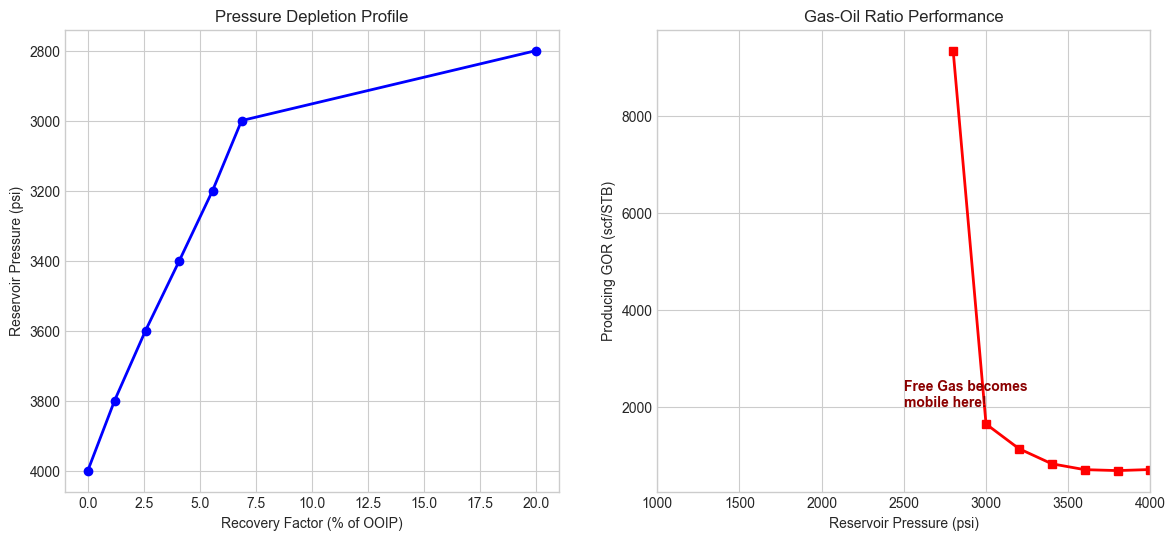

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Pressure vs Recovery
ax1.plot(df_results['RF'], df_results['Pressure'], 'b-o', linewidth=2)
ax1.set_xlabel('Recovery Factor (% of OOIP)')
ax1.set_ylabel('Reservoir Pressure (psi)')
ax1.set_title('Pressure Depletion Profile')
ax1.invert_yaxis() # Engineers usually like pressure dropping downwards on Y
ax1.grid(True)

# Plot 2: GOR vs Pressure
ax2.plot(df_results['Pressure'], df_results['GOR'], 'r-s', linewidth=2)
ax2.set_xlabel('Reservoir Pressure (psi)')
ax2.set_ylabel('Producing GOR (scf/STB)')
ax2.set_title('Gas-Oil Ratio Performance')
ax2.set_xlim(4000, 1000)
ax2.invert_xaxis() # Pressure decreases to the right
ax2.grid(True)

# Annotate the GOR surge
ax2.text(2500, 2000, 'Free Gas becomes\nmobile here!', color='darkred', fontweight='bold')


plt.show()

## Conclusion

Using the Tarner Method, we predicted that:
1.  The maximum recovery factor at 1000 psi is roughly **12-15%**. (Typical for solution gas drive without water support).
2.  The GOR skyrockets after pressure drops below 3000 psi, indicating we are depleting the reservoir energy by producing excess free gas.

**Engineering Value:**
This prediction tells management that unless we implement **Pressure Maintenance** (like Water Injection) or **Artificial Lift**, the natural energy of the reservoir is insufficient for high recovery.